In [16]:
# imports
import numpy as np
import krakenex as k
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import datetime
from pathlib import Path
import sys
from datetime import datetime, timedelta
from matplotlib import dates 


In [17]:
#set SQL BBDD
from sqlalchemy import create_engine, MetaData, Table, Column, DateTime, Float, String,Integer

dbInstance = 'sqlite:///krakenTeader.db'
dbBalanceHistoryTable = 'BalanceHistory'
dbTradesHistoryTable = 'TradesHistory'
dbMyHistoryTable = 'MyTrades'
engine = create_engine(dbInstance)

if not engine.dialect.has_table(engine, dbMyHistoryTable):  # If table don't exist, Create.
    metadata = MetaData(engine)
    
    # Create a table with the appropriate Columns
    Table(dbMyHistoryTable, metadata,
             Column('id', Integer, nullable=True), 
             Column('openTime', DateTime, nullable=True), 
             Column('closeTime', DateTime, nullable=True), 
             Column('tradeDescription', String, nullable=True), 
             Column('openingCH', Float, nullable=True), 
             Column('baseCH', Float, nullable=True), 
             Column('targetCH', Float, nullable=True), 
             Column('stopLoseCH', Float, nullable=True), 
             Column('TotalLoseCH', Float, nullable=True), 
             Column('closingCH', Float, nullable=True), 
             Column('deltaCH', Float, nullable=True), 
             Column('Profit', Float, nullable=True))
    # Implement the creation
    metadata.create_all() 

In [18]:

#preparar datos para plotear
BalanceHistory = pd.read_sql(dbBalanceHistoryTable, con=engine)
BalanceHistory = BalanceHistory.set_index(pd.DatetimeIndex(BalanceHistory['Time']))
BalanceHistory.drop('Time', axis=1,inplace=True)

#filtrar periodo de interes
windowTime = (24*7)
EndSampleTime = datetime(2017,11,9,0,0)
plotmin = True
HoursInterval = 1
if windowTime > 6: plotmin = False
if windowTime > 12: HoursInterval = 2
if windowTime > 24: HoursInterval = 4
if windowTime > 24 * 2: HoursInterval = 8
if windowTime > 24 * 5: HoursInterval = 12
if windowTime > 24 * 10: HoursInterval = 24
if windowTime > 24 * 15: HoursInterval = 48

verUltimo=True

if verUltimo:
    startSampleTime = datetime.now() + timedelta(hours=windowTime*-1)
    BalanceHistory = BalanceHistory[BalanceHistory.index > startSampleTime]
else:
    startSampleTime = EndSampleTime + timedelta(hours=windowTime*-1)
    BalanceHistory = BalanceHistory[(BalanceHistory.index >= startSampleTime) & (BalanceHistory.index <= EndSampleTime)]

#combertir el balance a un porcentaje entre -100% y 100%
BalanceHistory['balanceRatio'] = (BalanceHistory['balanceRatio'] - 0.5 )*2*100 

BalanceHistory['volbuy'] = BalanceHistory['volbuy'] / BalanceHistory['close']
BalanceHistory['volsell'] = BalanceHistory['volsell'] / BalanceHistory['close']
BalanceHistory['unbalance'] = BalanceHistory['unbalance'] / BalanceHistory['close']

#calcular %CH, %CH Acum , SMA %CH Acum
BalanceHistory['change'] = BalanceHistory['close'].pct_change(periods=1)*100
#BalanceHistory['cahnge2'] = BalanceHistory['close'] / BalanceHistory['close'].shift(1) -1 #equibalente 
BalanceHistory['cum_change'] = BalanceHistory['change'].cumsum()
BalanceHistory['SMA03_cum_change'] = BalanceHistory['cum_change'].rolling(5).mean()
BalanceHistory['SMA12_cum_change'] = BalanceHistory['cum_change'].rolling(12).mean()

#calcular sma de 3 periodos (suavisar el grafico)
BalanceHistory['EWM_unbalance'] =  BalanceHistory["unbalance"].ewm(span=3).mean()

#calcular la porsiocn negativa (para mostrar en rojo en el grafico)
BalanceHistory['EWM_unbalance_N'] = BalanceHistory['EWM_unbalance']
neg = BalanceHistory['EWM_unbalance_N']
neg[neg >= 0] = np.nan
BalanceHistory['EWM_unbalance_N'] = neg


comCompra = 0.29  
comVenta = 0.19 
spreadEntrada = 0.2 
spreadSalida = 0.2
deltaBaseCH = comCompra + comVenta + spreadEntrada + spreadSalida 

In [19]:
def Condensatetrades():
    
    tradesHistory = pd.read_sql(dbTradesHistoryTable, con=engine)
    tradesHistory.set_index(pd.DatetimeIndex(tradesHistory['time']),inplace=True)

    tradesCondensation =  pd.DataFrame(columns=['time','price','countb','volb','counts','vols'])

    if (len(tradesHistory) > 0) & (len(BalanceHistory) > 0):
        for i in range(len(BalanceHistory)):
            if i > 0:
                t0 = BalanceHistory.index[i]
                t1 = BalanceHistory.index[i-1]

                trades0 = tradesHistory[t1:t0]

                trades0b = trades0[trades0['buy_sell'] =='b']
                trades0s = trades0[trades0['buy_sell'] =='s']

                tradesCountb = len(trades0b)
                tradesCounts = len(trades0s)*-1

                price = trades0.price.mean()

                volb = trades0b.volume.sum()
                vols = trades0s.volume.sum()*-1

                new = [t0,price,tradesCountb,volb,tradesCounts,vols]
                tradesCondensation.loc[len(tradesCondensation)] = new
        #end for
        if (len(tradesCondensation) > 0):
            tradesCondensation.fillna(0,inplace=True)
            tradesCondensation.set_index(pd.DatetimeIndex(tradesCondensation['time']),inplace=True)
            tradesCondensation.drop('time',inplace=True,axis=1)

    return tradesCondensation

In [20]:
def upTrend (bh, td, volPriceOpen = 40000, chOpen = 0.5, mbOpen = 0.5, deltaCHObjetivo = 5, chClose = 1, deltaTotalLoseCH = 1, waitPeriods = 60, waitFactor = 48, waitPeriodsOutBase = 30, waitFactorOutBase = 5):

    comCompra = 0.29  
    comVenta = 0.19 
    spreadEntrada = 0.2 
    spreadSalida = 0.2
    deltaBaseCH = comCompra + comVenta + spreadEntrada + spreadSalida 

    deltaTargetCH = deltaBaseCH + deltaCHObjetivo
    deltaStopLose = deltaBaseCH - chClose

    inBase = False
    
    s = bh['unbalance']
    sma03 = bh['SMA03_cum_change']
    sma12 = bh['SMA12_cum_change']
    ch = bh['change']
    cumch = bh['cum_change']
    
    volb = td['volb']
    
    openPos = 0
    isOpen = False
    inBase = False
    
    sOpenCond = ""
    sCloseCond = ""
        
    #valores de cada operacion 
    openingCH = 0.0
    baseCH = 0.0
    targetCH = 0.0
    stopLoseCH = 0.0
    TotalLoseCH = 0.0
    closingCH = 0.0
    deltaCH = 0.0
    idTrade = 0
    openTime = datetime.now()
    closeTime =openTime

    cols = ['id','openTime','closeTime','tradeDescription','openingCH','baseCH','targetCH','stopLoseCH','TotalLoseCH','closingCH','deltaCH'] 
    myTrades = pd.DataFrame(columns=cols)
    
    for i in range(len(s)):
        if i > 12:
            if (isOpen == False):
                if i < len(td):
                    if(volb[i] * td['price'][i] >= volPriceOpen):
                        if (s[i] > 0) & (s[i-1] < 0):
                            if (sma03[i] > sma03[i-1]+ chOpen):# & (volb[i] > 50):
                                isOpen = True
                                sOpenCond = "MB UP 1"                
                        elif (s[i] > 0) & (s[i] > mbOpen): # & (volb[i] > 50):
                            isOpen = True
                            sOpenCond = "MB UP 2"                
                        elif (s[i] < 0) & (s[i-1] > s[i-2] + mbOpen*2): # & (volb[i] > 50):
                            isOpen = True
                            sOpenCond = "MB UP 3"                
                        elif ((sma03[i-1] < sma12[i-1]) & (sma03[i] > sma12[i])): 
                            if (sma03[i] > sma03[i-1]+ chOpen): #  & (volb[i] > 50):
                                isOpen = True
                                sOpenCond = "SMA03 UP"
                        elif (ch[i] > ch[i-1] + chOpen): 
                            if (sma03[i] > sma03[i-1]+ chOpen): # & (volb[i] > 50):
                                isOpen = True
                                sOpenCond = "CH UP"
                    """elif ((cumch[i] > cumch[i-2] + chOpen ) & (cumch[i-2] > cumch[i-4])):
                        isOpen = True
                        sOpenCond = "CH UP WITHOUT VOL" """
                
                if isOpen == True:
                    openPos = i
                    idTrade = idTrade + 1
                    sDesc = '({0}) ─► {1}'.format(idTrade, sOpenCond)
                    inBase = False
                    openTime = s.index[i]
                    openingCH = bh.cum_change[i]
                    baseCH = openingCH + deltaBaseCH
                    targetCH = openingCH + deltaTargetCH
                    stopLoseCH = openingCH + deltaStopLose
                    TotalLoseCH = openingCH - deltaTotalLoseCH
            
            if (isOpen == True):
                if bh.cum_change[i] >= baseCH: #nivel de perdidas operacionales superado
                    inBase = True
                
                if inBase == True: 
                    if bh.cum_change[i] >= targetCH: #objetivo cumplido
                        if s[i] < mbOpen: #dejar correr las ganancias
                            isOpen = False
                            sCloseCond = "TARGET ACCOMPLISHED AT {0} %CH".format(round(deltaTargetCH,2))
                        
                    if bh.cum_change[i] <= (stopLoseCH): #cierre por stop lose
                        isOpen = False
                        sCloseCond = "STOP LOSE AT {0} %CH".format(round(deltaStopLose,2))
                    elif (i >= (openPos + (waitPeriods*waitFactor))): #cierre por tiempo trascurrido sin logar objetivos
                        isOpen = False
                        sCloseCond = "elapsed {0} times without goals | IN BASE".format(waitPeriods*waitFactor)
                    """    
                    elif ((sma03[i-1] > sma12[i-1]) & (sma03[i] <= sma12[i])): #cierre por sma corta sma larga
                        isOpen = False
                        sCloseCond = "SMA03 DOWN"
                    """
                        
                else: #nivel de perdidas operacionales no se logro 
                    """if ((sma03[i-1] > sma12[i-1]) & (sma03[i] <= sma12[i])): #cierre por sma corta sma larga
                        isOpen = False
                        sCloseCond = "SMA03 DOWN" """
                    if (s[i] <= 0) &(bh.cum_change[i] < TotalLoseCH): #cierre por perdida total
                        isOpen = False
                        sCloseCond = "TOTAL LOSE"
                    elif (i >= (openPos + (waitPeriodsOutBase*waitFactorOutBase))): #cierre por tiempo trascurrido sin logar objetivos
                        isOpen = False
                        sCloseCond = "elapsed {0} times without goals | OUT BASE".format(waitPeriodsOutBase*waitFactorOutBase)

                if isOpen == False:
                    if (bh.cum_change[i] > (targetCH)):
                        isOpen = True
                        if bh.cum_change[i] <= (targetCH + 2):
                            isOpen = False
                            sCloseCond = "TARGET SUPERED AT {0} %CH".format(round(deltaTargetCH +2,2))
                    """elif inBase == True:
                        isOpen = True
                        if bh.cum_change[i] >= (targetCH - 1):
                            isOpen = False
                            sCloseCond = "TARGET NOT REACHED AT {0} %CH".format(round(deltaTargetCH -1,2)) """
                
                if isOpen == False:
                    #resC.append(s.index[i])
                    sDesc = sDesc + ' | {0}'.format(sCloseCond)
                    #resDesc.append(sDesc)
                    inBase = False
                    
                    #v2
                    closeTime = s.index[i]
                    closingCH = bh.cum_change[i]
                    if openingCH >= closingCH:
                        deltaCH = closingCH - openingCH
                    else:
                        deltaCH = closingCH - openingCH
                    newTrade = [idTrade,openTime,closeTime,sDesc,openingCH,baseCH,targetCH,stopLoseCH, TotalLoseCH,closingCH,deltaCH]
                    myTrades.loc[len(myTrades)] = newTrade   
                    #fin v2
                    
            if (i == len(s)) & (isOpen == True): #ultima posision y algun trade sigue abierto
                sDesc = sDesc + ' | IN PROGRESS'
                closeTime = s.index[i]
                closingCH = bh.cum_change[i]
                if openingCH >= closingCH:
                    deltaCH = closingCH - openingCH
                else:
                    deltaCH = closingCH - openingCH
                newTrade = [idTrade,openTime,closeTime,sDesc,openingCH,baseCH,targetCH,stopLoseCH, TotalLoseCH,closingCH,deltaCH]
                myTrades.loc[len(myTrades)] = newTrade
                
    print('Total Trades: {0}'.format(len(myTrades)))
    myTrades.set_index('id',inplace=True)

    return myTrades

In [21]:
def plotAllTrades():
    tradesCount = len(myTrades)
    if tradesCount > 0:
        fig, axes = plt.subplots(tradesCount, 2, figsize=(16,tradesCount*5))
        for i in range(tradesCount):
            n = i+1
            row = axes[i]
            dOpen = myTrades.openTime[n]
            iniPos = BalanceHistory.index.get_loc(dOpen)-10
            iniMoment = BalanceHistory.index[iniPos] 

            sDesc = myTrades.tradeDescription[n]
            if i  < tradesCount:
                dClose = myTrades.closeTime[n]
                endPos = BalanceHistory.index.get_loc(dClose)+0
                endMoment = BalanceHistory.index[endPos] 
            else:
                dClose = BalanceHistory.index.max()
                endMoment = BalanceHistory.index.max()

            df =  BalanceHistory[(BalanceHistory.index >= iniMoment) & (BalanceHistory.index <= endMoment)]

            #calcular %CH, %CH Acum , SMA %CH Acum
            #df['change'] = df['close'].pct_change(periods=1)*100
            #df['cum_change'] = df['change'].cumsum()
            #df['SMA03_cum_change'] = df['cum_change'].rolling(3).mean()
            #df['SMA12_cum_change'] = df['cum_change'].rolling(12).mean()
            plotTrade(row, df,dOpen, dClose, sDesc,myTrades.openingCH[n],myTrades.closingCH[n])

        fig.autofmt_xdate() 
        plt.legend() 
        plt.tight_layout() 
        plt.show()
    else:
        print('No trades for plot')

def plotTrade(ax, df, dOpen, dClose, sDesc, openCH,closeCH):
    ax[0].plot_date(df.index, df['volbuy'],'g--',alpha=0.5)
    ax[0].plot_date(df.index, df['volsell'],'r--',alpha=0.5)
    ax[0].plot_date(df.index, df['unbalance'],'bo-', markersize=3)
    #ax[0].plot_date(df.index, df['EWM_unbalance'],'bo-', markersize=3)
    #ax[0].plot_date(df.index, df['EWM_unbalance_N'],'ro-', markersize=3)
    ax[0].axvline(dOpen,ymin=-0,ymax=1,c="#05652F",linewidth=2,zorder=0)
    ax[0].axvline(dClose,ymin=-0,ymax=1,c="#F44C04",linewidth=2,zorder=0)
    ax[0].yaxis.grid(True) 
    ax[0].xaxis.grid(True) 
    ax[0].xaxis.set_minor_locator(dates.MinuteLocator(interval=10)) 
    ax[0].xaxis.set_minor_formatter(dates.DateFormatter('%d %H:%M'))
    ax[0].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')
    ax[0].legend(loc='best')
    ax[0].axhline(0,color='g',ls='-')
    ax[0].set_title(sDesc)

    ax[1].plot_date(df.index, df['cum_change'],'b-',alpha=0.4)
    ax[1].plot_date(df.index, df['SMA03_cum_change'],'go-', markersize=2)
    ax[1].plot_date(df.index, df['SMA12_cum_change'],'o-',color='#3366ff', markersize=2) #ligthBlue
    ax[1].axvline(dOpen,ymin=-0,ymax=1,c="#05652F",linewidth=2,zorder=0)
    ax[1].axvline(dClose,ymin=-0,ymax=1,c="#F44C04",linewidth=2,zorder=0)
    
    ax[1].axhline(openCH,xmin=-0,xmax=1,c="#05652F",linewidth=2,zorder=0)
    ax[1].axhline(closeCH,xmin=-0,xmax=1,c="#F44C04",linewidth=2,zorder=0)
    
    ax[1].yaxis.grid(True) 
    ax[1].xaxis.grid(True) 
    ax[1].xaxis.set_minor_locator(dates.MinuteLocator(interval=10)) 
    ax[1].xaxis.set_minor_formatter(dates.DateFormatter('%d %H:%M'))
    ax[1].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')
    ax[1].legend(loc='best')
    ax[1].axhline(0,color='b',ls='-')

In [22]:
def plotHistory(plotVolume=False, plotTrades=False):
    fig,ax = plt.subplots( sharex=True, figsize=(16,14), nrows=4, ncols=1)

    #plot price
    ax[0].plot_date(BalanceHistory.index, BalanceHistory['close'],'orange',marker='o', markersize=1)
    ax[0].yaxis.grid(True) 
    ax[0].xaxis.grid(True) 
    ax[0].xaxis.set_major_locator(dates.HourLocator(interval=HoursInterval)) 
    ax[0].xaxis.set_major_formatter(dates.DateFormatter('\n %d-%m %H'))
    if plotmin ==True:
        ax[0].xaxis.set_minor_locator(dates.MinuteLocator(interval=5))
        ax[0].xaxis.set_minor_formatter(dates.DateFormatter('%M'))
        ax[0].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')

    ax[0].set_title('CLOSE')
    ax[0].legend(loc='best')

    #plot %CH short SMA Large SMA
    ax[1].plot_date(BalanceHistory.index, BalanceHistory['change'],'ro-', markersize=1)
    ax[1].plot_date(BalanceHistory.index, BalanceHistory['cum_change'],'b-',alpha=0.4)
    ax[1].plot_date(BalanceHistory.index, BalanceHistory['SMA03_cum_change'],'go-', markersize=1) #ligthBlue
    ax[1].yaxis.grid(True) 
    ax[1].xaxis.grid(True) 
    ax[1].xaxis.set_major_locator(dates.HourLocator(interval=HoursInterval)) 
    ax[1].xaxis.set_major_formatter(dates.DateFormatter('\n %d-%m %H'))
    if plotmin ==True:
        ax[1].xaxis.set_minor_locator(dates.MinuteLocator(interval=5))
        ax[1].xaxis.set_minor_formatter(dates.DateFormatter('%M'))
        ax[1].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')

    ax[1].set_title('% CHANGE - CUMULATIVE CHANGE')
    ax[1].legend(loc='best')
    ax[1].axhline(0,color='g',ls='-')

    #plot  MarquetBalance
    ax[2].plot_date(BalanceHistory.index, BalanceHistory['volbuy'],'g--',alpha=0.5)
    ax[2].plot_date(BalanceHistory.index, BalanceHistory['volsell'],'r--',alpha=0.5) 
    #ax[2].plot_date(BalanceHistory.index, BalanceHistory['unbalance'],'bo-', markersize=3)
    ax[2].plot_date(BalanceHistory.index, BalanceHistory['EWM_unbalance'],'bo-', markersize=1)
    ax[2].plot_date(BalanceHistory.index, BalanceHistory['EWM_unbalance_N'],'ro-', markersize=1)

    ax[2].yaxis.grid(True) 
    ax[2].xaxis.grid(True) 
    ax[2].xaxis.set_major_locator(dates.HourLocator(interval=HoursInterval)) 
    ax[2].xaxis.set_major_formatter(dates.DateFormatter('\n %d-%m %H'))
    if plotmin ==True:
        ax[2].xaxis.set_minor_locator(dates.MinuteLocator(interval=5))
        ax[2].xaxis.set_minor_formatter(dates.DateFormatter('%M'))
        ax[2].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')

    ax[2].set_title('volbuy - volsell- unbalance')
    ax[2].legend(loc='best')
    #ax[2].axhline(0,color='g',ls='-')

    # plot volumen
    if plotVolume == True:
        ax[3].plot_date(tradesCondensation.index, tradesCondensation['volb'],'g',marker='o', markersize=3)
        ax[3].plot_date(tradesCondensation.index, tradesCondensation['vols'],'r',marker='o', markersize=3)
        ax[3].yaxis.grid(True) 
        ax[3].xaxis.grid(True) 
        ax[3].xaxis.set_major_locator(dates.HourLocator(interval=HoursInterval)) 
        ax[3].xaxis.set_major_formatter(dates.DateFormatter('\n %d-%m %H'))
        if plotmin ==True:
            ax[3].xaxis.set_minor_locator(dates.MinuteLocator(interval=5))
            ax[3].xaxis.set_minor_formatter(dates.DateFormatter('%M'))
            ax[3].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')

        ax[3].set_title('VOLUMEN POR PERIODO')
        ax[3].legend(loc='best')
        ax[3].axhline(0,color='g',ls='-')

    if plotTrades == True:
        for d in  myTrades.openTime:
            ax[0].axvline(d,ymin=-1.2,ymax=1,c="#05652F",linewidth=2,zorder=0, clip_on=False)
            ax[1].axvline(d,ymin=-1.2,ymax=1,c="#05652F",linewidth=2,zorder=0, clip_on=False)
            ax[2].axvline(d,ymin=-1.2,ymax=1,c="#05652F",linewidth=2,zorder=0, clip_on=False)
            ax[3].axvline(d,ymin=0,ymax=1,c="#05652F",linewidth=2,zorder=0, clip_on=False)

        for d in myTrades.closeTime:
            ax[0].axvline(d,ymin=-1.2,ymax=1,c="#ffaa80",linewidth=2,zorder=0, clip_on=False)
            ax[1].axvline(d,ymin=-1.2,ymax=1,c="#ffaa80",linewidth=2,zorder=0, clip_on=False)
            ax[2].axvline(d,ymin=-1.2,ymax=1,c="#ffaa80",linewidth=2,zorder=0, clip_on=False)
            ax[3].axvline(d,ymin=0,ymax=1,c="#ffaa80",linewidth=2,zorder=0, clip_on=False)


In [23]:
def plotProfit():
    if len(myTrades) > 0:
        myTrades['Profit'] = myTrades['deltaCH'].cumsum()
        totalCom = len(myTrades) * deltaBaseCH
        totalWin = myTrades.deltaCH.sum()
        finalBalance = totalWin - totalCom
        print('total win: {0}, total commiciones: {1}, Balance Final {2}'.format( totalWin,totalCom,finalBalance))
        if len(myTrades) > 1:
            myTrades['Profit'].plot()

In [24]:
tradesCondensation = Condensatetrades()

In [25]:
myTrades = upTrend(BalanceHistory, tradesCondensation, volPriceOpen = 50000, chOpen = 0.2, mbOpen =0.9, deltaCHObjetivo = 20)

Total Trades: 4


total win: -2.3212743904687123, total commiciones: 3.5199999999999996, Balance Final -5.841274390468712


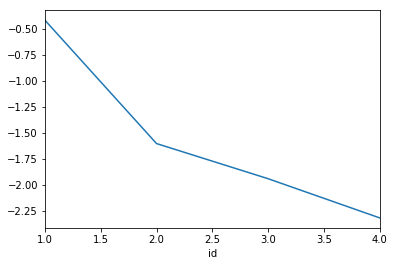

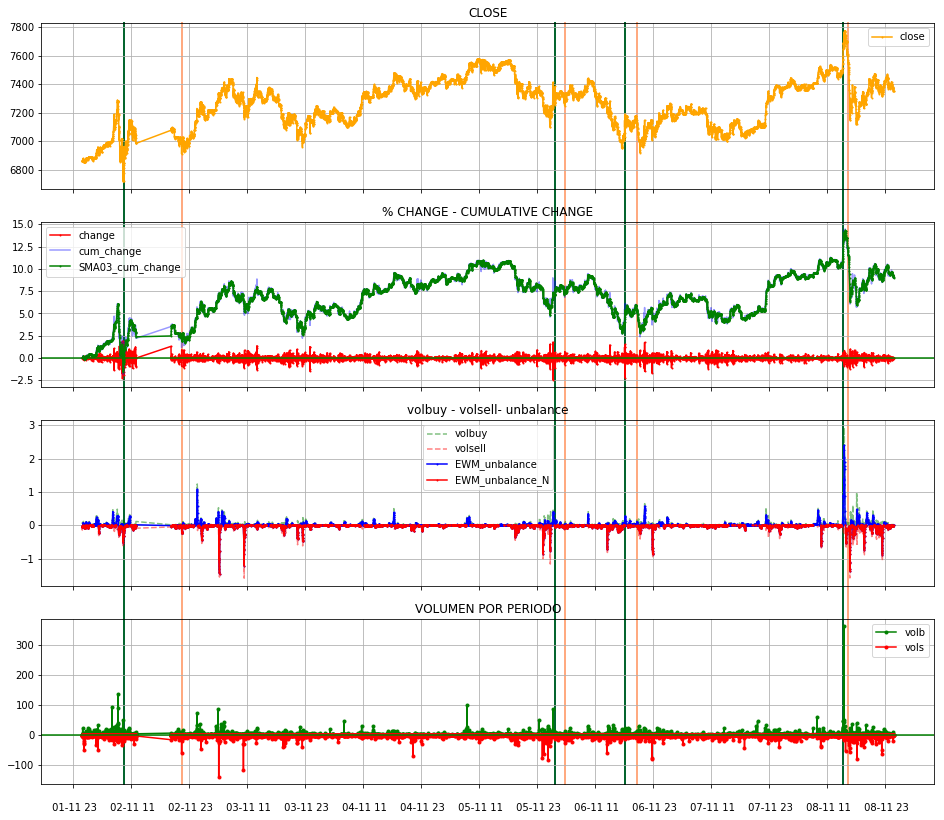

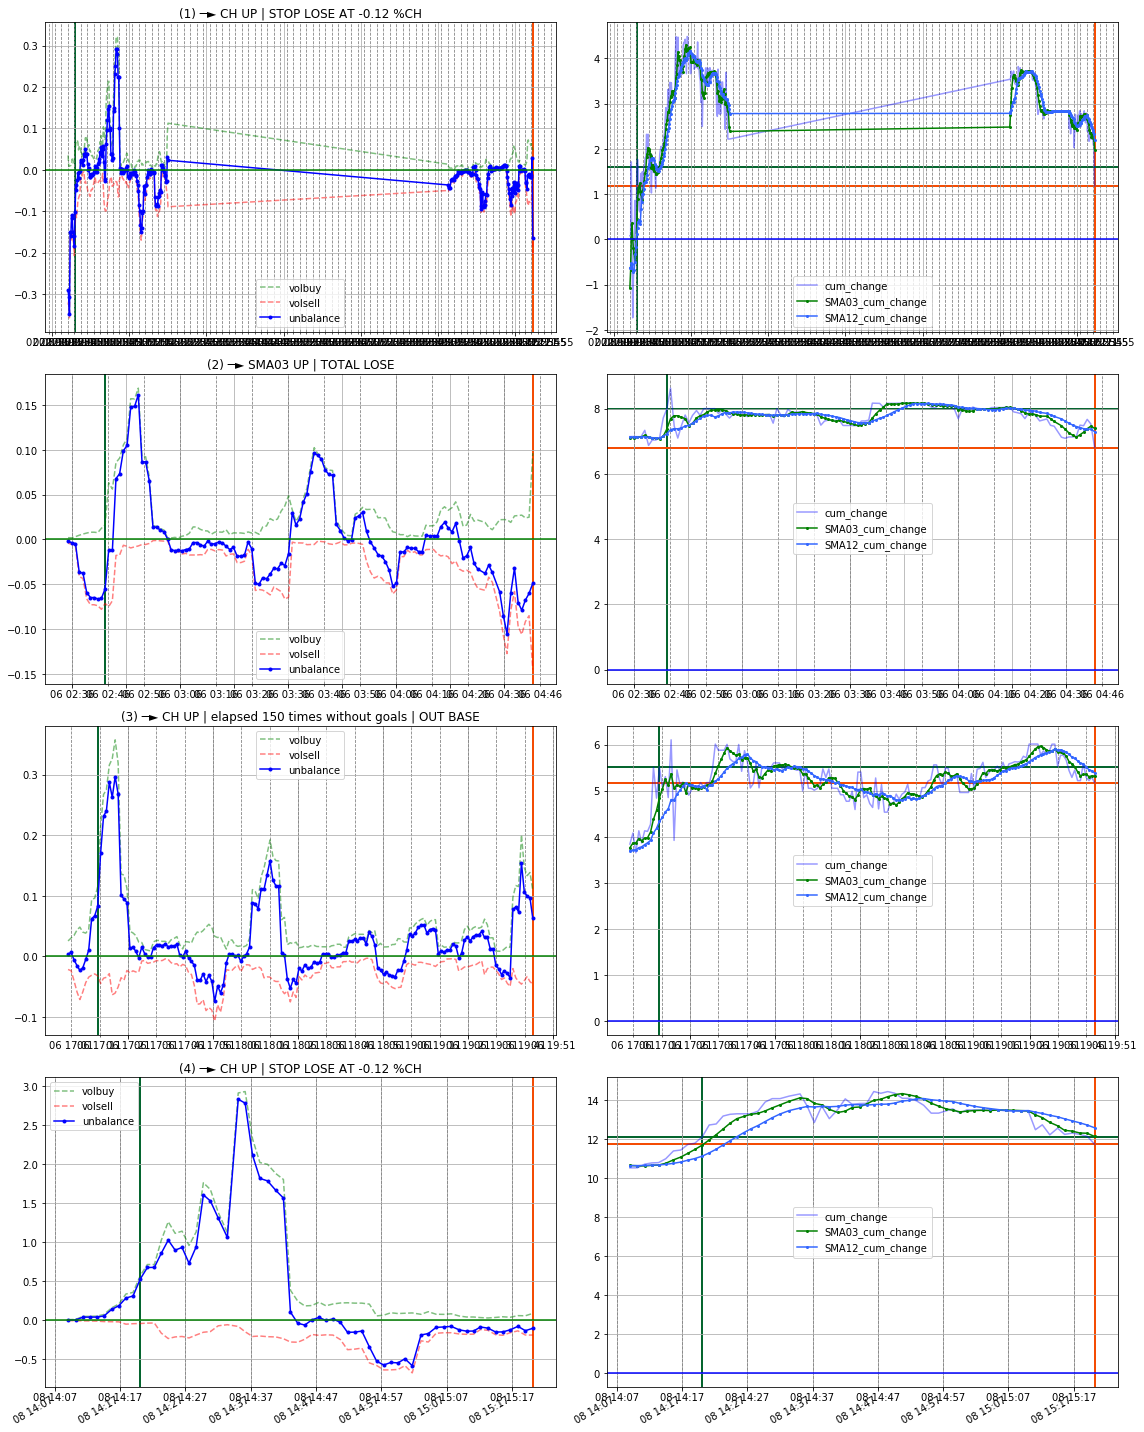

In [26]:
plotProfit()
plotHistory(plotVolume=True, plotTrades=True)
plotAllTrades()

In [27]:
deltaVol = tradesCondensation['volb'].sum() + tradesCondensation['vols'].sum()
deltaVol

-114.53486689000056

In [28]:
myTrades

,openTime,closeTime,tradeDescription,openingCH,baseCH,targetCH,stopLoseCH,TotalLoseCH,closingCH,deltaCH,Profit
id,,,,,,,,,,,
1,2017-11-02 09:36:05.363539,2017-11-02 21:27:05.796701,(1) ─► CH UP | STOP LOSE AT -0.12 %CH,1.596924,2.476924,22.476924,1.476924,0.596924,1.182502,-0.414422,-0.414422
2,2017-11-06 02:45:12.270965,2017-11-06 04:44:00.874698,(2) ─► SMA03 UP | TOTAL LOSE,7.992464,8.872464,28.872464,7.872464,6.992464,6.802758,-1.189706,-1.604128
3,2017-11-06 17:10:16.306706,2017-11-06 19:43:54.526958,(3) ─► CH UP | elapsed 150 times without goals...,5.511082,6.391082,26.391082,5.391082,4.511082,5.171984,-0.339098,-1.943225
4,2017-11-08 14:20:06.778945,2017-11-08 15:20:11.944122,(4) ─► CH UP | STOP LOSE AT -0.12 %CH,12.118031,12.998031,32.998031,11.998031,11.118031,11.739982,-0.378049,-2.321274


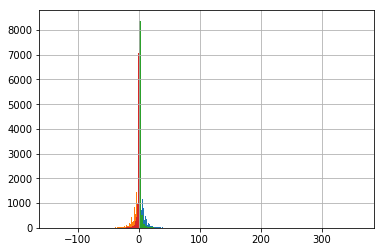

In [29]:
tradesCondensation['countb'].hist(bins=100)
tradesCondensation['counts'].hist(bins=100)
tradesCondensation['volb'].hist(bins=100)
tradesCondensation['vols'].hist(bins=100)

In [30]:
"""
tradesHistory = pd.read_sql(dbTradesHistoryTable, con=engine)
tradesHistory.set_index(pd.DatetimeIndex(tradesHistory['time']),inplace=True)
tradesHistory.head()
tradesHistory.tail(10)
print(tradesCondensation['volb'].last_valid_index())
# limpiar datros corrompidos
import sqlite3
conn = sqlite3.connect('krakenTeader.db')
c = conn.cursor()
mydata = c.execute("DELETE FROM TradesHistory WHERE time=?", ("2102-05-08 07:47:11.736900",))
conn.commit()
c.close
"""

'\ntradesHistory = pd.read_sql(dbTradesHistoryTable, con=engine)\ntradesHistory.set_index(pd.DatetimeIndex(tradesHistory[\'time\']),inplace=True)\ntradesHistory.head()\ntradesHistory.tail(10)\nprint(tradesCondensation[\'volb\'].last_valid_index())\n# limpiar datros corrompidos\nimport sqlite3\nconn = sqlite3.connect(\'krakenTeader.db\')\nc = conn.cursor()\nmydata = c.execute("DELETE FROM TradesHistory WHERE time=?", ("2102-05-08 07:47:11.736900",))\nconn.commit()\nc.close\n'